# BN Generation Parameter Sweep

This notebook sweeps over DAG/BN generation parameters outlined in `notebooks/graph_generation/ideas.md` and materializes multiple discrete BN variants per DAG.

It varies:
- n (number of variables)
- target treewidth
- variable arity (fixed or range)
- CPT skewness (Dirichlet alpha)
- determinism fraction (mostly 0%)

Outputs:
- CSV with per-variant metadata
- On-screen CPT previews for a small sample



In [11]:
import sys
from pathlib import Path
import re
from os import getenv

# Ensure src is importable
repo_root = Path(".").resolve().parents[1]
sys.path.append(str(repo_root / 'src'))

from graph_generation import generate_dag_with_treewidth
from bn_generation import generate_variants_for_dag
from cpd_utils import cpd_to_ascii_table
from discrete.discrete_inference import format_probability_query, query_probability
from llm_calling import run_llm_call
from yaml_utils import load_yaml

import pandas as pd
import numpy as np
from openai import OpenAI



In [12]:
# LLM Configuration and Helper Functions
MODEL = "openai/o3-mini-high"  # Change this to your preferred model
MODEL = "deepseek/deepseek-chat-v3.1:free"

# Initialize OpenAI client
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=getenv("OPENROUTER_API_KEY")
)

# Load prompts
prompt_path = repo_root / "notebooks" / "discrete" / "prompts.yaml"
prompts = load_yaml(prompt_path)

def extract_numeric_answer(response_text):
    """Extract numeric probability from LLM response."""
    # Look for patterns like "Final Answer: P(...) = 0.1234" or "= 0.1234"
    patterns = [
        r"Final Answer:.*?=\s*([0-9]*\.?[0-9]+)",
        r"=\s*([0-9]*\.?[0-9]+)\s*$",
        r"probability[:\s]*([0-9]*\.?[0-9]+)",
        r"([0-9]*\.?[0-9]+)\s*$"
    ]
    
    for pattern in patterns:
        matches = re.findall(pattern, response_text, re.IGNORECASE | re.MULTILINE)
        if matches:
            try:
                return float(matches[-1])  # Take the last match
            except ValueError:
                continue
    
    return None

def create_llm_prompt(bn, query_vars, query_states, evidence):
    """Create a machine-readable prompt for LLM inference."""
    # Generate CPTs as ASCII tables
    cpd_strings = []
    for cpd in bn.get_cpds():
        cpd_strings.append(cpd_to_ascii_table(cpd))
    cpds_as_string = "\n\n".join(cpd_strings)
    
    # Create query string
    if len(query_vars) == 1:
        query_str = format_probability_query(query_vars[0], query_states[0], evidence)
    else:
        # For joint queries, create a custom format
        evidence_str = ', '.join([f"{k}={v}" for k, v in evidence.items()]) if evidence else ""
        query_parts = [f"{var}={state}" for var, state in zip(query_vars, query_states)]
        query_str = f"P({', '.join(query_parts)}" + (f" | {evidence_str})" if evidence_str else ")")
    
    # Create machine-readable prompt
    prompt_str = f"""You are a probability calculator. Compute the exact probability for the given query.

Conditional Probability Tables:
{cpds_as_string}

Query: {query_str}

Instructions:
1. Use exact inference methods (variable elimination, etc.)
2. Show your work step by step
3. Provide the final answer in this exact format: Final Answer: {query_str} = [NUMBER]

Where [NUMBER] is the exact probability as a decimal (e.g., 0.1234)."""

    return prompt_str

def call_llm_for_query(bn, query_vars, query_states, evidence):
    """Call LLM to get probability for a specific query."""
    try:
        prompt_str = create_llm_prompt(bn, query_vars, query_states, evidence)
        
        messages = [
            {"role": "system", "content": "You are a probability calculator. Provide exact numerical answers."},
            {"role": "user", "content": prompt_str}
        ]
        
        response, _ = run_llm_call(
            openai_client=client,
            model=MODEL,
            messages=messages
        )
        
        if response:
            numeric_answer = extract_numeric_answer(response)
            return numeric_answer, response
        else:
            return None, None
            
    except Exception as e:
        print(f"Error calling LLM: {e}")
        return None, None


In [13]:
# Parameter grids (edit as needed)
ns = [7, 11, 15]
treewidths = [2, 3, 4]
arity_specs = [
    #{"type": "fixed", "fixed": 2},
    {"type": "range", "min": 2, "max": 3},
]
dirichlet_alphas = [0.5, 1.0]
determinism_fracs = [0.0, 0.1]  # mostly 0%; includes a nonzero test
naming_strategies = ['simple', 'confusing', 'semantic']  # Add naming strategy variation
variants_per_combo = 2
base_seed = 42

rows = []
preview_samples = []



In [14]:
def arity_to_str(spec):
    if spec["type"] == "fixed":
        return f"fixed:{spec['fixed']}"
    return f"range:{spec['min']}-{spec['max']}"

sample_counter = 0
all_bayesian_networks = []  # Store all BNs and their metadata

for n in ns:
    for tw in treewidths:
        for naming in naming_strategies:
            dag, achieved_tw, _ = generate_dag_with_treewidth(n, tw, node_naming=naming, seed=base_seed + sample_counter)
            for arity in arity_specs:
                for alpha in dirichlet_alphas:
                    for det in determinism_fracs:
                        cfgs = []
                        for i in range(variants_per_combo):
                            cfgs.append({
                                "arity_strategy": arity,
                                "dirichlet_alpha": alpha,
                                "determinism_fraction": det,
                            })
                        variants = generate_variants_for_dag(dag, cfgs, base_seed=base_seed + sample_counter)
                        for idx, (bn, meta) in enumerate(variants):
                            # Store BN and its metadata for later access
                            all_bayesian_networks.append({
                                "bn": bn,
                                "meta": {
                                    "n": n,
                                    "target_tw": tw,
                                    "achieved_tw": achieved_tw,
                                    "naming": naming,
                                    "arity": arity_to_str(arity),
                                    "alpha": meta["dirichlet_alpha"],
                                    "determinism": meta["determinism_fraction"],
                                    "seed": meta["seed"],
                                    "variant_index": idx,
                                    "num_edges": bn.number_of_edges(),
                                    "num_nodes": bn.number_of_nodes(),
                                }
                            })
                            rows.append({
                                "n": n,
                                "target_tw": tw,
                                "achieved_tw": achieved_tw,
                                "naming": naming,
                                "arity": arity_to_str(arity),
                                "alpha": meta["dirichlet_alpha"],
                                "determinism": meta["determinism_fraction"],
                                "seed": meta["seed"],
                                "variant_index": idx,
                                "num_edges": bn.number_of_edges(),
                                "num_nodes": bn.number_of_nodes(),
                            })
                            if sample_counter < 3:  # collect a few previews
                                preview_samples.append(bn)
                        sample_counter += 1



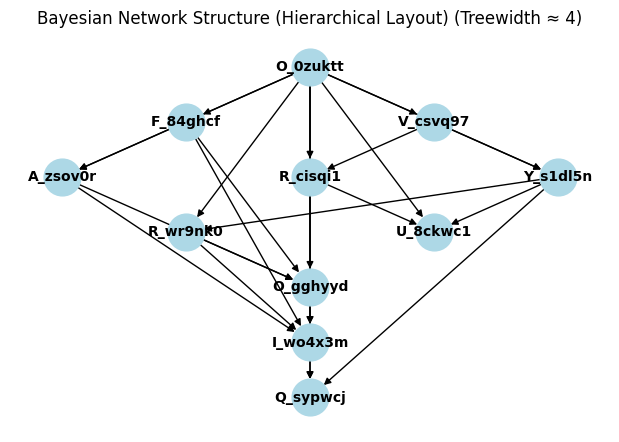

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Draw the first network in all_bayesian_networks
if all_bayesian_networks:
    from bn_utils import draw_bayesian_network
    bn0 = all_bayesian_networks[130]["bn"]
    draw_bayesian_network(bn0, node_size=700, node_color='lightblue', font_size=10, figsize=(6, 4))
else:
    print("No Bayesian networks to display.")


In [16]:
df = pd.DataFrame(rows)
display(df.head())
print(f"Total variants: {len(df)}")

# Save CSV next to notebook
out_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep.csv'
df.to_csv(out_csv, index=False)
print('Saved to', out_csv)



,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,num_nodes
0,7,2,2,simple,range:2-3,0.5,0.0,42,0,7,7
1,7,2,2,simple,range:2-3,0.5,0.0,10015,1,7,7
2,7,2,2,simple,range:2-3,0.5,0.1,43,0,7,7
3,7,2,2,simple,range:2-3,0.5,0.1,10016,1,7,7
4,7,2,2,simple,range:2-3,1.0,0.0,44,0,7,7


Total variants: 216
Saved to /home/bmihaljevic/repos/code-projects/aily/probabilistic-reasoning-llms/notebooks/graph_generation/bn_generation_sweep.csv


In [17]:
# Preview a few CPTs from the first few variants
from cpd_utils import cpd_to_ascii_table

for i, bn in enumerate(preview_samples[:3]):
    print(f"\n### Preview BN {i}")
    for cpd in bn.get_cpds():
        print(cpd_to_ascii_table(cpd))
        print()




### Preview BN 0
+-------------+-------------+
| Node(Value) | Probability |
+-------------+-------------+
| V0(s0)      | 0.0116      |
+-------------+-------------+
| V0(s1)      | 0.9884      |
+-------------+-------------+

+-------------+-------------+
| Node(Value) | Probability |
+-------------+-------------+
| V2(s0)      | 0.1066      |
+-------------+-------------+
| V2(s1)      | 0.8934      |
+-------------+-------------+

+--------+--------+--------+
| V0     | V0(s0) | V0(s1) |
+--------+--------+--------+
| V3(s0) | 0.2456 | 0.1419 |
+--------+--------+--------+
| V3(s1) | 0.1704 | 0.7014 |
+--------+--------+--------+
| V3(s2) | 0.5839 | 0.1567 |
+--------+--------+--------+

+--------+--------+--------+
| V0     | V0(s0) | V0(s1) |
+--------+--------+--------+
| V4(s0) | 0.0287 | 0.7633 |
+--------+--------+--------+
| V4(s1) | 0.8433 | 0.0584 |
+--------+--------+--------+
| V4(s2) | 0.1280 | 0.1783 |
+--------+--------+--------+

+--------+--------+--------+
| V0   

In [ ]:

# For each Bayesian network, generate 5 queries using generate_queries, run them, and collect results
from query_generation import QuerySpec, generate_queries
from pgmpy.inference import VariableElimination

# Store all queries for later recovery: a list of lists (per BN)
all_bn_queries = []

query_rows = []

for idx, bn_dict in enumerate(all_bayesian_networks):
    bn = bn_dict["bn"]
    # Use a different seed per BN for query generation for reproducibility
    query_seed = 1000 + idx
    # Generate 5 queries for this BN
    queries = generate_queries(
        bn,
        num_queries=5,
        query_node_counts=(1, 2),
        evidence_counts=(0, 1, 2),
        distance_buckets=[(1, 1), (2, 3), (1, 3)],
        seed=query_seed,
    )
    all_bn_queries.append(queries)
    # Get the BN's properties from the main df
    bn_row = df.iloc[idx].to_dict()
    for qidx, query in enumerate(queries):
        # Prepare inference
        infer = VariableElimination(bn)
        # Query variables and their states
        query_vars = [v for v, _ in query.targets]
        query_states = [s for _, s in query.targets]
        # Evidence dict: variable -> state
        evidence = query.evidence if query.evidence else None

        # Compute exact probability
        try:
            # pgmpy: query returns a factor, we need to index into the right assignment
            result = infer.query(variables=query_vars, evidence=evidence, show_progress=False)
            # result is a DiscreteFactor, get the probability for the assignment
            # The order of query_vars matches the order of query_states
            assignment = dict(zip(query_vars, query_states))
            prob = result.get_value(**assignment)
        except Exception as e:
            prob = None

        # Collect all info for the table, merging BN and query properties (no LLM here)
        row = dict(bn_row)  # copy BN properties
        row.update({
            "bn_index": idx,
            "query_index": qidx,
            "query_vars": str(query_vars),
            "query_states": str(query_states),
            "evidence": str(query.evidence),
            "distance": query.meta.get("min_target_evidence_distance"),
            "num_evidence": query.meta.get("num_evidence_nodes"),
            "probability": prob,
        })
        query_rows.append(row)

# Convert to DataFrame and display
full_df = pd.DataFrame(query_rows)
print(f"Total queries: {len(full_df)}")



# Optionally, save the full query+BN dataframe
out_query_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep_queries.csv'
full_df.to_csv(out_query_csv, index=False)
print('Saved query+BN results to', out_query_csv)



In [9]:
# Optional: Call LLM on a subset AFTER query generation
# Provide indices of rows in full_df for which to call the LLM.
import ast, re

def _parse_field(val):
    if isinstance(val, (list, dict)):
        return val
    if not isinstance(val, str):
        return val
    s = val.strip()
    if not s:
        return None
    # Normalize np.str_('X') -> 'X'
    s = re.sub(r"np\.str_\(\'([^']*)\'\)", r"'\\1'", s)
    s = re.sub(r'np\.str_\("([^"]*)"\)', r"'\\1'", s)
    try:
        return ast.literal_eval(s)
    except Exception:
        return val

# Ensure LLM columns exist
if 'llm_probability' not in full_df.columns:
    full_df['llm_probability'] = None
if 'llm_response' not in full_df.columns:
    full_df['llm_response'] = None

# Select which rows to send to LLM (example below commented out)
# selected_indices = list(full_df.sample(n=10, random_state=0).index)
selected_indices = [330]  # e.g., [0, 15, 42]

for ridx in selected_indices:
    row = full_df.iloc[ridx]
    bn = all_bayesian_networks[int(row['bn_index'])]['bn']
    query_vars = _parse_field(row['query_vars']) or []
    query_states = _parse_field(row['query_states']) or []
    evidence = _parse_field(row['evidence']) or None
    print(f"Processing BN {int(row['bn_index'])+1}/{len(all_bayesian_networks)}, Query {int(row['query_index'])+1}...")
    llm_prob, llm_response = call_llm_for_query(bn, query_vars, query_states, evidence)
    full_df.at[full_df.index[ridx], 'llm_probability'] = llm_prob
    full_df.at[full_df.index[ridx], 'llm_response'] = llm_response


# Save the DataFrame with LLM responses to a CSV file
out_llm_csv = out_query_csv.replace(".csv", "_with_llm.csv")
full_df.to_csv(out_llm_csv, index=False)
print("Saved DataFrame with LLM responses to", out_llm_csv)



Processing BN 67/216, Query 1...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


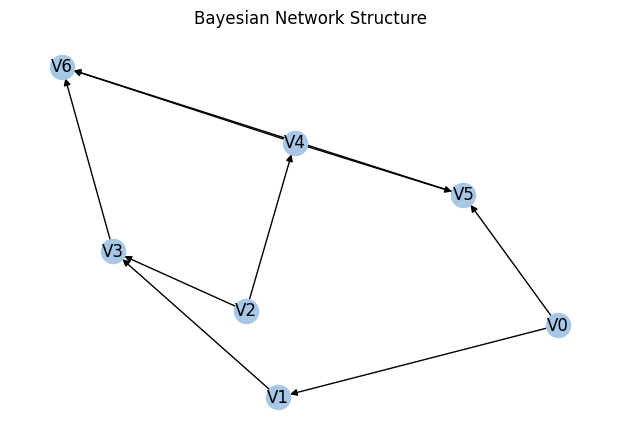

Query: P(V0=s2, V4=s0 | V6=s0, V5=s1)
Exact probability: 0.3609384613129887


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


LLM probability: 0.3609
Absolute error: 3.846131298868016e-05
{'query': 'P(V0=s2, V4=s0 | V6=s0, V5=s1)', 'exact_probability': 0.3609384613129887, 'llm_probability': 0.3609, 'delta': 3.846131298868016e-05, 'llm_response': 'We wish to compute\n\n\u2003\u2003P(V0 = s2, V4 = s0 | V6 = s0, V5 = s1) = \n\u2003\u2003\u2003\u2003[P(V0 = s2, V4 = s0, V6 = s0, V5 = s1)]\n\u2003\u2003\u2003\u2003———————————————\n\u2003\u2003\u2003\u2003\u2003\u2003P(V6 = s0, V5 = s1).\n\nIn our “Bayesian network” the complete joint factorizes as\n\n\u2003\u2003P(V2) · P(V0) · P(V4 | V2) · P(V1 | V0) · P(V5 | V4,V0) · P(V3 | V2,V1) · P(V6 | V3,V4,V5).\n\nThus (with all probabilities read from the tables)\n\n\u2003\u2003P(V0 = s2, V4 = s0, V6 = s0, V5 = s1)\n\u2003\u2003\u2002 = P(V0 = s2) · P(V5 = s1 | V4 = s0, V0 = s2)\n\u2003\u2003\u2003\u2003× Σ₍v₂₎ P(V2 = v₂) · P(V4 = s0 | v₂)\n\u2003\u2003\u2003\u2003\u2003\u2003× [ Σ₍v₁₎ P(V1 = v₁ | V0 = s2) ·\n\u2003\u2003\u2003\u2003\u2003\u2003\u2003\u2003\u2003\u2003[ Σ

In [10]:
# Inspect a single row: draw BN, call LLM, compare\n
from bn_generation import inspect_row_and_call_llm
# Choose a row index from full_df\n
row_index = 140  # e.g., 0 or any valid index\n
result = inspect_row_and_call_llm(
    full_df=full_df,
    all_bayesian_networks=all_bayesian_networks,
    row_index=row_index,
    openai_client=client,
    model=MODEL,
    draw_kwargs={"figsize": (6, 4)},
)
print(result)

In [15]:
# Display LLM performance statistics
print("LLM Performance Analysis:")
print("=" * 50)

# Count successful LLM responses
successful_llm = full_df['llm_probability'].notna().sum()
total_queries = len(full_df)
print(f"Successful LLM responses: {successful_llm}/{total_queries} ({successful_llm/total_queries*100:.1f}%)")

# Calculate accuracy metrics for successful responses
if successful_llm > 0:
    # Filter to only successful LLM responses
    successful_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()]
    
    if len(successful_df) > 0:
        # Calculate absolute errors
        successful_df = successful_df.copy()
        successful_df['abs_error'] = abs(successful_df['llm_probability'] - successful_df['probability'])
        successful_df['rel_error'] = successful_df['abs_error'] / successful_df['probability']
        
        print(f"\nAccuracy Metrics (for {len(successful_df)} successful responses):")
        print(f"Mean Absolute Error: {successful_df['abs_error'].mean():.6f}")
        print(f"Mean Relative Error: {successful_df['rel_error'].mean():.6f}")
        print(f"Max Absolute Error: {successful_df['abs_error'].max():.6f}")
        print(f"Max Relative Error: {successful_df['rel_error'].max():.6f}")
        
        # Show some examples
        print(f"\nFirst 5 successful responses:")
        display(successful_df[['query_vars', 'query_states', 'evidence', 'probability', 'llm_probability', 'abs_error']].head())
    else:
        print("No successful LLM responses with exact inference results to compare.")
else:
    print("No successful LLM responses.")


LLM Performance Analysis:
Successful LLM responses: 1/960 (0.1%)

Accuracy Metrics (for 1 successful responses):
Mean Absolute Error: 0.184835
Mean Relative Error: 2.622774
Max Absolute Error: 0.184835
Max Relative Error: 2.622774

First 5 successful responses:


,query_vars,query_states,evidence,probability,llm_probability,abs_error
3,"[np.str_('V2'), np.str_('V0')]","['s1', 's0']",{},0.070473,0.255308,0.184835


In [11]:
# Save enhanced results with LLM data
enhanced_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep_queries_with_llm.csv'
full_df.to_csv(enhanced_csv, index=False)
print(f'Saved enhanced results with LLM data to {enhanced_csv}')

# Also save a summary of LLM performance
if successful_llm > 0 and len(successful_df) > 0:
    summary_stats = {
        'total_queries': total_queries,
        'successful_llm_responses': successful_llm,
        'success_rate': successful_llm/total_queries*100,
        'mean_absolute_error': successful_df['abs_error'].mean(),
        'mean_relative_error': successful_df['rel_error'].mean(),
        'max_absolute_error': successful_df['abs_error'].max(),
        'max_relative_error': successful_df['rel_error'].max(),
    }
    
    summary_df = pd.DataFrame([summary_stats])
    summary_csv = repo_root / 'notebooks' / 'graph_generation' / 'llm_performance_summary.csv'
    summary_df.to_csv(summary_csv, index=False)
    print(f'Saved LLM performance summary to {summary_csv}')


Saved enhanced results with LLM data to /home/bmihaljevic/repos/code-projects/aily/probabilistic-reasoning-llms/notebooks/graph_generation/bn_generation_sweep_queries_with_llm.csv


In [12]:
# Print 5 rows above and below row 456 of full_df (i.e., rows 451 to 461 inclusive)
ind = 829
start_idx = max(0, ind - 5)
end_idx = min(len(full_df), ind + 6)  # +6 because end is exclusive
display(full_df.iloc[start_idx:end_idx])


,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,...,bn_index,query_index,query_vars,query_states,evidence,distance,num_evidence,probability,llm_probability,llm_response
824,8,2,2,confusing,fixed:2,1.0,0.0,124,0,8,...,164,4,[np.str_('P_v5go95')],['s1'],"{np.str_('P_0kmqp8'): 's0', np.str_('S_sof43o'...",2,2,0.544442,None,None
825,8,2,2,confusing,fixed:2,1.0,0.0,10097,1,8,...,165,0,"[np.str_('S_sof43o'), np.str_('Z_fnjzcq')]","['s0', 's0']","{np.str_('P_v5go95'): 's1', np.str_('L_gvxijs'...",1,2,0.213750,None,None
826,8,2,2,confusing,fixed:2,1.0,0.0,10097,1,8,...,165,1,"[np.str_('P_0kmqp8'), np.str_('Z_fnjzcq')]","['s0', 's1']","{np.str_('S_vt5lo2'): 's0', np.str_('S_sof43o'...",2,2,0.634390,None,None
827,8,2,2,confusing,fixed:2,1.0,0.0,10097,1,8,...,165,2,"[np.str_('X_qap0v6'), np.str_('P_0kmqp8')]","['s1', 's0']","{np.str_('S_vt5lo2'): 's0', np.str_('Z_fnjzcq'...",2,2,0.684251,None,None
828,8,2,2,confusing,fixed:2,1.0,0.0,10097,1,8,...,165,3,[np.str_('X_qap0v6')],['s1'],{np.str_('L_gvxijs'): 's1'},2,1,0.685399,None,None
829,8,2,2,confusing,fixed:2,1.0,0.0,10097,1,8,...,165,4,"[np.str_('T_tn6upr'), np.str_('X_qap0v6')]","['s0', 's0']",{},0,0,0.094172,None,None
830,8,2,2,confusing,fixed:2,1.0,0.1,125,0,8,...,166,0,[np.str_('S_vt5lo2')],['s0'],"{np.str_('T_tn6upr'): 's0', np.str_('P_v5go95'...",1,2,0.818983,None,None
831,8,2,2,confusing,fixed:2,1.0,0.1,125,0,8,...,166,1,[np.str_('P_0kmqp8')],['s0'],{},0,0,0.029277,None,None
832,8,2,2,confusing,fixed:2,1.0,0.1,125,0,8,...,166,2,"[np.str_('L_gvxijs'), np.str_('X_qap0v6')]","['s0', 's1']",{np.str_('Z_fnjzcq'): 's0'},1,1,0.098173,None,None
833,8,2,2,confusing,fixed:2,1.0,0.1,125,0,8,...,166,3,"[np.str_('Z_fnjzcq'), np.str_('S_vt5lo2')]","['s0', 's0']","{np.str_('L_gvxijs'): 's0', np.str_('P_v5go95'...",1,2,0.049343,None,None


In [13]:

# Get the 493rd row (index 2) of the DataFrame
row = full_df.iloc[ind]

# Extract identifying info for the BN and query
bn_index = row['bn_index']
query_index = row['query_index']

# Recover the BN and query from the sweep results
bn_dict = all_bayesian_networks[bn_index]
bn = bn_dict["bn"]
query = all_bn_queries[bn_index][query_index]

from pgmpy.inference import VariableElimination

# Prepare inference
infer = VariableElimination(bn)
query_vars = [v for v, _ in query.targets]
query_states = [s for _, s in query.targets]
evidence = query.evidence if query.evidence else None

# Compute probability
try:
    result = infer.query(variables=query_vars, evidence=evidence, show_progress=False)
    assignment = dict(zip(query_vars, query_states))
    prob = result.get_value(**assignment)
except Exception as e:
    prob = None

print("BN index:", bn_index)
print("Query index:", query_index)
print("Query variables:", query_vars)
print("Query states:", query_states)
print("Evidence:", evidence)
print("Probability:", prob)



BN index: 165
Query index: 4
Query variables: [np.str_('T_tn6upr'), np.str_('X_qap0v6')]
Query states: ['s0', 's0']
Evidence: None
Probability: 0.09417218846726567
